In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy 
import os
import re
import MDAnalysis
import nmrglue as ng
%matplotlib inline

# This is the analysis notebook for KcsA Deactivated state
The trajactory is based on PDB 5KVE and 100 ns MD simulation, frames are saved every 100 ps and of the 1000 saved frames, 1/10 are evenly sampled to run restrainted minimized, results of which are used for AF-NMR MM/QM calculation 

Data location:  [data path](../../kcsa_100ns_0111/results_minimized_0130)
MD trajctory:/Users/yunyao_1/Dropbox/KcsA/kcsa_inactivation3/kcsa_inactivation_3_trj
calcualted CS results:/Users/yunyao_1/Dropbox/KcsA/kcsa_100ns_0111/results_minimized_0130
Mimimized snapshots:/Users/yunyao_1/Dropbox/KcsA/kcsa_100ns_0111/snapshots_minimized_0130

# Caution
when selecting residue in mdanalysis
## use this way to select a residue instead of using the index!!!!!
residue = u.select_atoms(f"resid {256}").residues[0]
use MDanalysis index start from zero, could easy cause a mismatch

In [3]:
#directory for calcuated chemical shift inforamtion
dir_cc='/Users/yunyao_1/Dropbox/KcsA/kcsa_100ns_0111/results_minimized_0130'
# read files that starts with results
ccdeactivated_dict={}
for file in os.listdir(dir_cc):
    if file[0]=='r':
        full_f=os.path.join(dir_cc,file)
        ccdeactivated_dict[file.rstrip('.txt')]=pd.read_csv(full_f, sep='\t', header=None, names=['resNO','atom','resNam','iso','delta','ita','alpha','betta','gamma'])
            
        

In [4]:
#test if data were correctly read
if 'results_0' in ccdeactivated_dict.keys():
    print('yes')

yes


In [5]:
#first to check chemical shift for V76 ang G77 residues
#index for V77:V76_index=[76-22+n*103+1 for n in range(4)]
#index for G77:
#testing whether indexing is right
'''
V76_index=[76-22+n*103+1 for n in range(4)]
V76_index
[55, 158, 261, 364]
match with the QM output indexing
'''


'\nV76_index=[76-22+n*103+1 for n in range(4)]\nV76_index\n[55, 158, 261, 364]\nmatch with the QM output indexing\n'

In [29]:
# a glimpse of the QM output
ccdeactivated_dict['results_0']

,resNO,atom,resNam,iso,delta,ita,alpha,betta,gamma,frame
0,50,C,GLU,176.730,81.275,0.949,15.152,-68.205,92.262,0
1,51,N,THR,114.821,107.043,0.126,19.136,172.946,186.454,0
2,51,H,THR,5.738,5.697,0.434,21.765,29.074,31.548,0
3,51,CA,THR,72.823,-23.743,0.142,103.419,106.794,140.720,0
4,51,HA,THR,3.922,1.965,0.436,27.313,29.831,30.688,0
...,...,...,...,...,...,...,...,...,...,...
467,369,HD13,LEU,1.168,-7.107,0.184,27.824,29.133,39.139,0
468,369,CD2,LEU,21.930,-20.420,0.373,153.850,161.471,188.290,0
469,369,HD21,LEU,0.997,-6.020,0.364,28.097,30.288,38.223,0
470,369,HD22,LEU,0.419,-5.131,0.264,29.540,30.893,37.912,0


In [30]:
import re
import pandas as pd

# Assuming ccdeactivated_dict is already defined
for key in ccdeactivated_dict.keys():
    # Extract frame number and assign it
    frame_number = int(re.findall(r'\d+', key)[0])
    ccdeactivated_dict[key]['frame'] = [frame_number] * len(ccdeactivated_dict[key])
    
    # Assign residue numbers safely
    ccdeactivated_dict[key]['resNO'] = ccdeactivated_dict[key]['resNO'].apply(
        lambda x: int(x) if str(x).isdigit() else None
    )

# Combine all data into a single DataFrame
ccdeactivated_df = pd.concat(ccdeactivated_dict.values(), ignore_index=True)

# Drop rows with invalid residue numbers and sort the DataFrame
ccdeactivated_df.dropna(subset=['resNO'], inplace=True)
ccdeactivated_df['resNO'] = ccdeactivated_df['resNO'].astype(int)
ccdeactivated_df.sort_values(by=['frame', 'resNO'], inplace=True)

# Check the data
print(ccdeactivated_df.head())

# Save the cleaned data to a CSV file
ccdeactivated_df.to_csv('KcsA_Deactivated_df_MMQM_CS.csv', index=False)


# plot the chemical shift for V76 and G77

      resNO atom resNam      iso    delta    ita    alpha    betta    gamma  \
9381     50    C    GLU  176.730   81.275  0.949   15.152  -68.205   92.262   
9382     51    N    THR  114.821  107.043  0.126   19.136  172.946  186.454   
9383     51    H    THR    5.738    5.697  0.434   21.765   29.074   31.548   
9384     51   CA    THR   72.823  -23.743  0.142  103.419  106.794  140.720   
9385     51   HA    THR    3.922    1.965  0.436   27.313   29.831   30.688   

      frame  
9381      0  
9382      0  
9383      0  
9384      0  
9385      0  


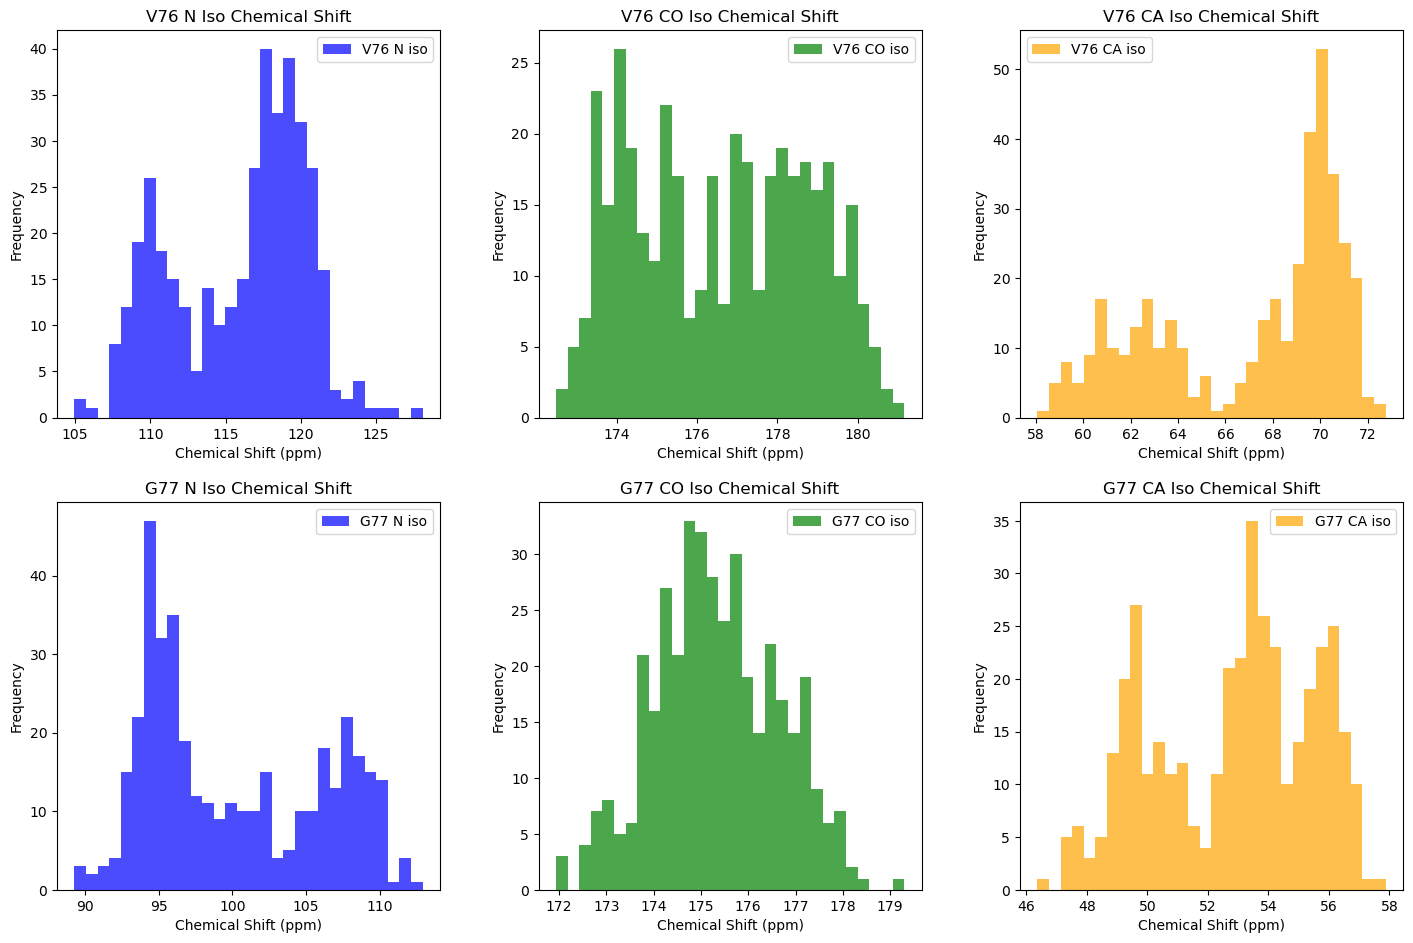

In [32]:
import matplotlib.pyplot as plt

# Define indices for residues
V76_index = [76 - 22 + n * 103 + 1 for n in range(4)]
G77_index = [77 - 22 + n * 103 + 1 for n in range(4)]

# Filter rows for V76 and exclude rows where 'atom' starts with 'H'
V76_df = ccdeactivated_df[
    ccdeactivated_df['resNO'].isin(V76_index) & 
    (~ccdeactivated_df['atom'].astype(str).str.startswith('H'))
].copy()

# Filter rows for G77 and exclude rows where 'atom' starts with 'H'
G77_df = ccdeactivated_df[
    ccdeactivated_df['resNO'].isin(G77_index) & 
    (~ccdeactivated_df['atom'].astype(str).str.startswith('H'))
].copy()

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=4.0)  # Adjust spacing between subplots

# Define colors for N, C, CA
colors = {'N': 'blue', 'C': 'green', 'CA': 'orange'}

# Plot histograms for V76
axes[0, 0].hist(V76_df[V76_df['atom'] == 'N']['iso'], bins=30, alpha=0.7, color=colors['N'], label='V76 N iso')
axes[0, 0].set_title('V76 N Iso Chemical Shift')
axes[0, 0].set_xlabel('Chemical Shift (ppm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

axes[0, 1].hist(V76_df[V76_df['atom'] == 'C']['iso'], bins=30, alpha=0.7, color=colors['C'], label='V76 CO iso')
axes[0, 1].set_title('V76 CO Iso Chemical Shift')
axes[0, 1].set_xlabel('Chemical Shift (ppm)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[0, 2].hist(V76_df[V76_df['atom'] == 'CA']['iso'], bins=30, alpha=0.7, color=colors['CA'], label='V76 CA iso')
axes[0, 2].set_title('V76 CA Iso Chemical Shift')
axes[0, 2].set_xlabel('Chemical Shift (ppm)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# Plot histograms for G77
axes[1, 0].hist(G77_df[G77_df['atom'] == 'N']['iso'], bins=30, alpha=0.7, color=colors['N'], label='G77 N iso')
axes[1, 0].set_title('G77 N Iso Chemical Shift')
axes[1, 0].set_xlabel('Chemical Shift (ppm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].hist(G77_df[G77_df['atom'] == 'C']['iso'], bins=30, alpha=0.7, color=colors['C'], label='G77 CO iso')
axes[1, 1].set_title('G77 CO Iso Chemical Shift')
axes[1, 1].set_xlabel('Chemical Shift (ppm)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

axes[1, 2].hist(G77_df[G77_df['atom'] == 'CA']['iso'], bins=30, alpha=0.7, color=colors['CA'], label='G77 CA iso')
axes[1, 2].set_title('G77 CA Iso Chemical Shift')
axes[1, 2].set_xlabel('Chemical Shift (ppm)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

# Show the plot
plt.show()


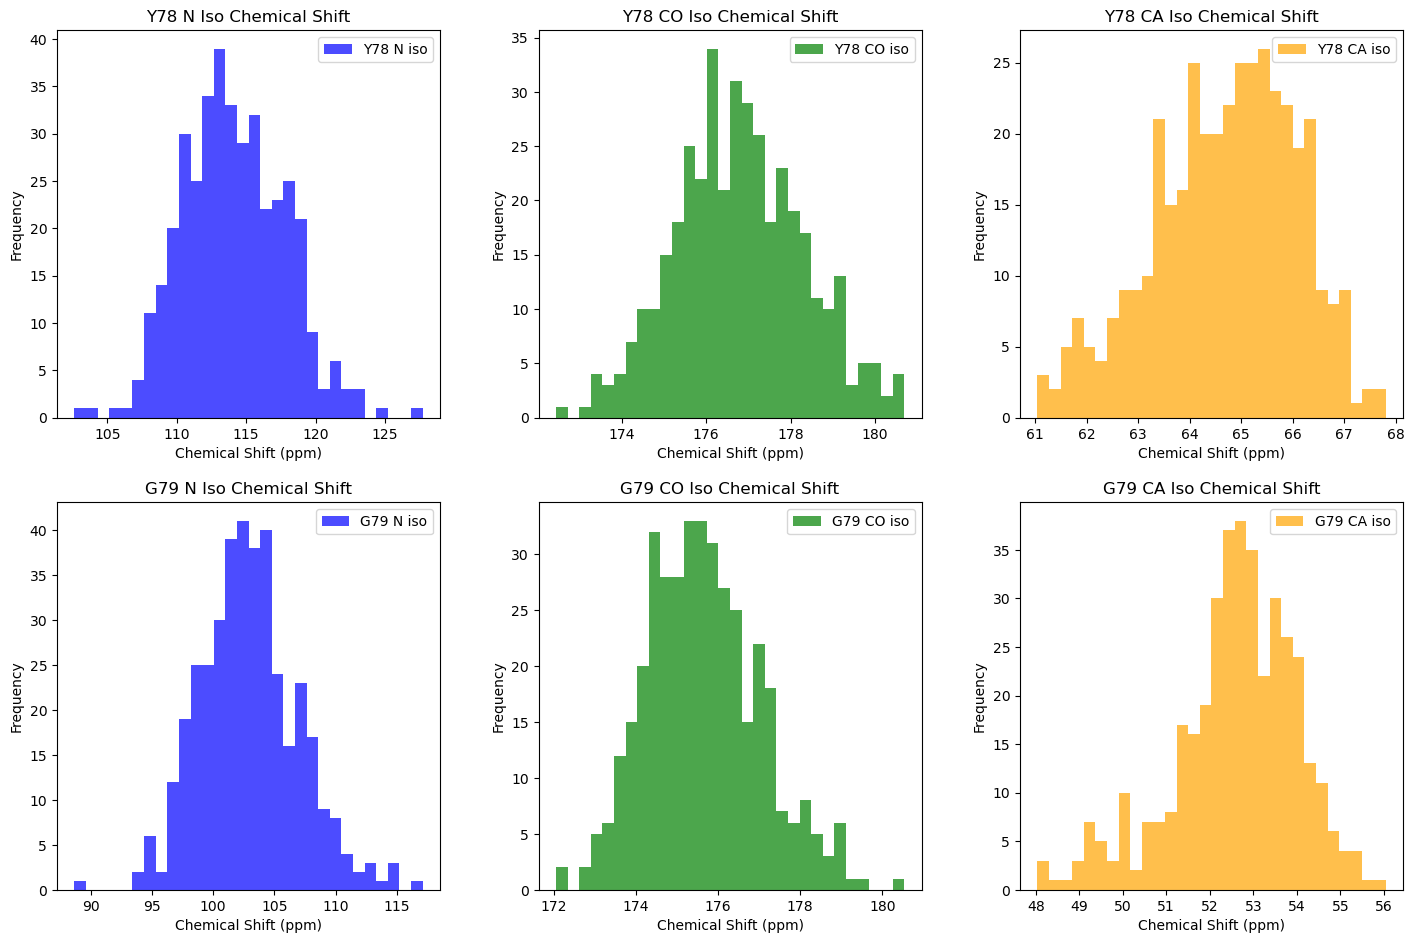

In [17]:
import matplotlib.pyplot as plt

# Define indices for residues
Y78_index = [78 - 22 + n * 103 + 1 for n in range(4)]
G79_index = [79 - 22 + n * 103 + 1 for n in range(4)]

# Filter rows for Y78 and exclude rows where 'atom' starts with 'H'
Y78_df = ccdeactivated_df[
    ccdeactivated_df['resNO'].isin(Y78_index) &
    (~ccdeactivated_df['atom'].astype(str).str.startswith('H'))
].copy()

# Filter rows for G79 and exclude rows where 'atom' starts with 'H'
G79_df = ccdeactivated_df[
    ccdeactivated_df['resNO'].isin(G79_index) &
    (~ccdeactivated_df['atom'].astype(str).str.startswith('H'))
].copy()

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=4.0)  # Adjust spacing between subplots

# Define colors for N, C, CA
colors = {'N': 'blue', 'C': 'green', 'CA': 'orange'}

# Plot histograms for Y78
axes[0, 0].hist(Y78_df[Y78_df['atom'] == 'N']['iso'], bins=30, alpha=0.7, color=colors['N'], label='Y78 N iso')
axes[0, 0].set_title('Y78 N Iso Chemical Shift')
axes[0, 0].set_xlabel('Chemical Shift (ppm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

axes[0, 1].hist(Y78_df[Y78_df['atom'] == 'C']['iso'], bins=30, alpha=0.7, color=colors['C'], label='Y78 CO iso')
axes[0, 1].set_title('Y78 CO Iso Chemical Shift')
axes[0, 1].set_xlabel('Chemical Shift (ppm)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[0, 2].hist(Y78_df[Y78_df['atom'] == 'CA']['iso'], bins=30, alpha=0.7, color=colors['CA'], label='Y78 CA iso')
axes[0, 2].set_title('Y78 CA Iso Chemical Shift')
axes[0, 2].set_xlabel('Chemical Shift (ppm)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# Plot histograms for G79
axes[1, 0].hist(G79_df[G79_df['atom'] == 'N']['iso'], bins=30, alpha=0.7, color=colors['N'], label='G79 N iso')
axes[1, 0].set_title('G79 N Iso Chemical Shift')
axes[1, 0].set_xlabel('Chemical Shift (ppm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].hist(G79_df[G79_df['atom'] == 'C']['iso'], bins=30, alpha=0.7, color=colors['C'], label='G79 CO iso')
axes[1, 1].set_title('G79 CO Iso Chemical Shift')
axes[1, 1].set_xlabel('Chemical Shift (ppm)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

axes[1, 2].hist(G79_df[G79_df['atom'] == 'CA']['iso'], bins=30, alpha=0.7, color=colors['CA'], label='G79 CA iso')
axes[1, 2].set_title('G79 CA Iso Chemical Shift')
axes[1, 2].set_xlabel('Chemical Shift (ppm)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

# Show the plot
plt.show()


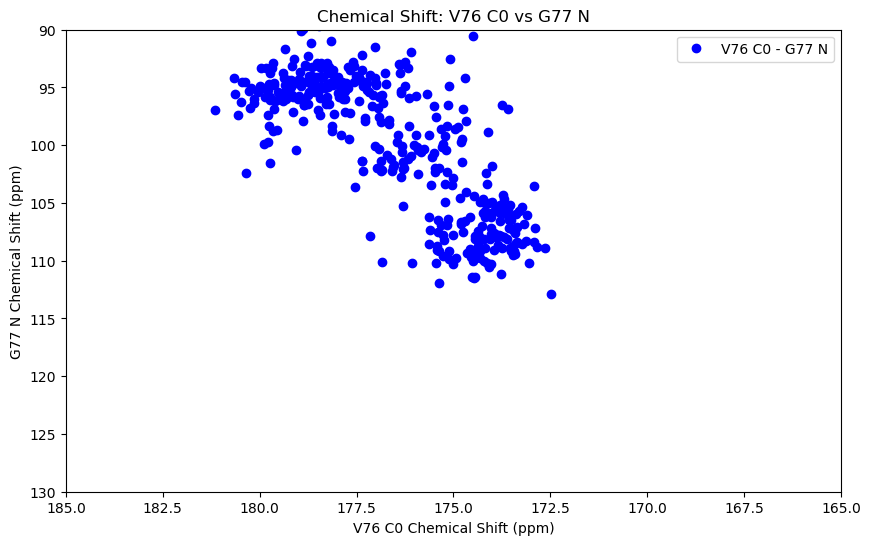

In [33]:
#plot the chemical shift for V76 C0- G77 N
plt.figure(figsize=(10, 6))
# convert data to numpy arrays for plotting
CO= np.array(V76_df[V76_df['atom'] == 'C']['iso'])
N = np.array(G77_df[G77_df['atom'] == 'N']['iso'])      
plt.plot(CO, N, marker='o', linestyle='None', color='blue', label='V76 C0 - G77 N')
plt.title('Chemical Shift: V76 C0 vs G77 N')
plt.xlabel('V76 C0 Chemical Shift (ppm)')
plt.ylabel('G77 N Chemical Shift (ppm)')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
plt.xlim(185, 165)
plt.ylim(130, 90)
#plt.grid()
plt.legend()
plt.show()
#plt.plot(V76_df[V76_df['atom'] == 'C']['iso'], G77_df[G77_df['atom'] == 'N']['iso'],marker='o', label='NCO')

In [46]:
ccdeactivated_df.head()

,resNO,atom,resNam,iso,delta,ita,alpha,betta,gamma,frame
9381,50,C,GLU,176.730,81.275,0.949,15.152,-68.205,92.262,0
9382,51,N,THR,114.821,107.043,0.126,19.136,172.946,186.454,0
9383,51,H,THR,5.738,5.697,0.434,21.765,29.074,31.548,0
9384,51,CA,THR,72.823,-23.743,0.142,103.419,106.794,140.720,0
9385,51,HA,THR,3.922,1.965,0.436,27.313,29.831,30.688,0


In [ ]:
import numpy as np
import MDAnalysis
import pandas as pd
import os
from MDAnalysis.analysis.dihedrals import Dihedral

# Function to calculate torsion angles for a residue
def calculate_torsion_angles(u, resid):
    """
    Calculate the phi and psi torsion angles for a given residue ID
    cautions:
    - The residue index is 0-based in MDAnalysis, so adjust accordingly.
    
    Parameters:
    u (MDAnalysis Universe): The universe containing the structure.
    residues (list): Residue number for which torsion angles are calculated.
    
    Returns:
    tuple: (phi angle, psi angle) in degrees.
    """
    try:
        # Select atoms for phi and psi calculations
        residue = u.select_atoms(f"resid {resid}").residues[0]
        phi_atoms = residue.phi_selection()
        psi_atoms = residue.psi_selection()
        
        # Calculate dihedral angles
        dihedral_phi = Dihedral([phi_atoms]).run()
        dihedral_psi = Dihedral([psi_atoms]).run()

        #  # Extract and format the results to 3 decimal places
        phi_angle = dihedral_phi.results.angles[0]
        psi_angle = dihedral_psi.results.angles[0]
        
        return phi_angle, psi_angle
    except Exception as e:
        # Handle residues without valid torsion angles
        return None, None

# Directory containing the structure files
data_dir = '/Users/yunyao_1/Dropbox/KcsA/kcsa_100ns_0111/snapshots_minimized_0130'

# Get all PDB files in the directory
pdb_files = [f for f in os.listdir(data_dir) if f.endswith('.pdb')]

# Unique residue numbers from the DataFrame
residues = pd.to_numeric(ccdeactivated_df['resNO'], errors='coerce').dropna().astype(int).unique()

# List to store torsion angle results
results = []

# Process each PDB file
for pdb_file in pdb_files[:5]:
    # Extract frame number from file name:kcsa_100ns_0111/snapshots_minimized_0130/kcsa_100ns_schrodinger_10.pdb
    frame_number = int(pdb_file.split('_')[3].split('.')[0])  # Assuming the frame number is in the file name
    #print(frame_number)
    # Load the PDB file into MDAnalysis Universe
    u = MDAnalysis.Universe(os.path.join(data_dir, pdb_file))
    
    # Calculate torsion angles for all residues
    for residue in residues[:5]:
        torsion_phi, torsion_psi = calculate_torsion_angles(u, residue) # Adjust for 0-based indexing in MDAnalysis
        print(f"Frame: {frame_number}, Residue: {residue}, residue_type:{u.select_atoms(f'resid {residue}').residues[0].resname} Phi: {torsion_phi}, Psi: {torsion_psi}")
        if torsion_phi is not None and torsion_psi is not None:
            results.append({
                'frame': frame_number,
                'residue': residue,
                'torsion_angle_phi': torsion_phi[0],
                'torsion_angle_psi': torsion_psi[0]
            })

#Convert results to a DataFrame
torsion_angles = pd.DataFrame(results)

#Save to CSV (optional)
torsion_angles.to_csv('Deactivated_torsion_angles.csv', index=False)

print("Torsion angle calculations completed!")


/Users/yunyao_1/miniforge3/envs/KcsA_torsion/lib/python3.8/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


Frame: 800, Residue: 50, residue_type:GLU Phi: [-62.30599155], Psi: [-39.12499974]
Frame: 800, Residue: 51, residue_type:THR Phi: [-78.95544777], Psi: [-32.31618245]
Frame: 800, Residue: 52, residue_type:ALA Phi: [-80.50412924], Psi: [-32.84138]
Frame: 800, Residue: 53, residue_type:THR Phi: [-87.51930487], Psi: [-10.12968126]
Frame: 800, Residue: 54, residue_type:THR Phi: [77.22854865], Psi: [36.08396031]
Frame: 380, Residue: 50, residue_type:GLU Phi: [-63.73731484], Psi: [-37.45427686]
Frame: 380, Residue: 51, residue_type:THR Phi: [-78.31735157], Psi: [-30.66433147]
Frame: 380, Residue: 52, residue_type:ALA Phi: [-79.82383654], Psi: [-39.85069174]
Frame: 380, Residue: 53, residue_type:THR Phi: [-75.11673355], Psi: [-21.16158564]
Frame: 380, Residue: 54, residue_type:THR Phi: [76.47707557], Psi: [42.21380318]
Frame: 960, Residue: 50, residue_type:GLU Phi: [-63.31798908], Psi: [-34.40972717]
Frame: 960, Residue: 51, residue_type:THR Phi: [-71.33839582], Psi: [-40.96514102]
Frame: 960,

In [ ]:
# Convert results to a DataFrame
torsion_angles = pd.DataFrame(results)
torsion_angles.head(10)
# show reisudes in u
# for res in u.residues:
#     if res.resid in residues:
#         print(res.resid, res.resnam

# use this way to select a residue instead of using the index!!!!!
residue = u.select_atoms(f"resid {256}").residues[0]
residue

<Residue GLU, 256>

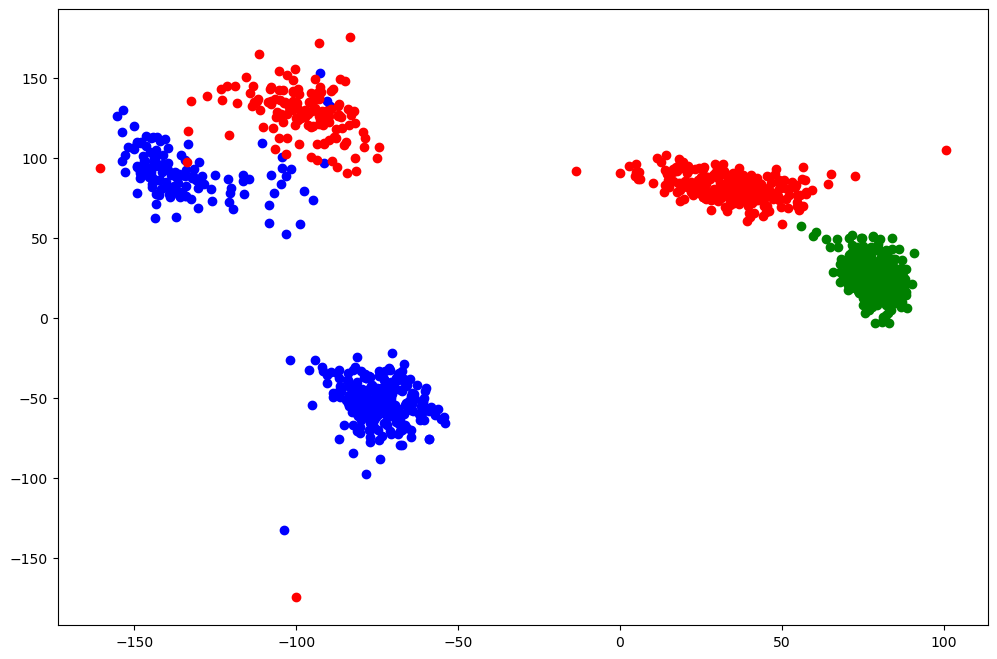

In [95]:
# let's plot the torsion angles for V76 and G77 residues
import matplotlib.pyplot as plt
# Define indices for residues
T75_index = [75 - 22 + n * 103 + 1 for n in range(4)]  # V76
V76_index = [76 - 22 + n * 103 + 1 for n in range(4)]
G77_index = [77 - 22 + n * 103 + 1 for n in range(4)]
# Filter rows for V76 and G77 residues
T75_torsion = torsion_angles[torsion_angles['residue'].isin(T75_index)]
V76_torsion = torsion_angles[torsion_angles['residue'].isin(V76_index)]
G77_torsion = torsion_angles[torsion_angles['residue'].isin(G77_index)]
# Create 2x2 subplots
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
# Plot phi angles for V76
T75_phi = np.array(T75_torsion['torsion_angle_phi'])
T75_psi = np.array(T75_torsion['torsion_angle_psi'])
v76_phi = np.array(V76_torsion['torsion_angle_phi'])
v76_psi = np.array(V76_torsion['torsion_angle_psi'])
G77_phi = np.array(G77_torsion['torsion_angle_phi'])
G77_psi = np.array(G77_torsion['torsion_angle_psi'])
axes.scatter(v76_phi,v76_psi, marker='o', linestyle='-', color='blue', label='V76 Phi')
axes.scatter(G77_phi, G77_psi, marker='o', linestyle='-', color='red', label='G77 Phi')
axes.scatter(T75_phi, T75_psi, marker='o', linestyle='-', color='green', label='T75 Phi')

#PLOT 


In [98]:
# merge the torsion angles with the chemical shift data
torsion_angles['resNO'] = torsion_angles['residue']  # Rename for merging
# covert to float for merging
torsion_angles['torsion_angle_phi'] = torsion_angles['torsion_angle_phi'].astype(float)
torsion_angles['torsion_angle_psi'] = torsion_angles['torsion_angle_psi'].astype(float)
merged_df = pd.merge(ccdeactivated_df, torsion_angles, on=['frame', 'resNO'], how='left')
## Save the merged DataFrame to a CSV file
merged_df.to_csv('KcsA_Deactivated_df_MMQM_CS_Torsion.csv', index=False)

# For classification based on torsion angle, we will do it in a seperate notebook

Following code is old, only kept for records.

In [ ]:
# classify the frame into 0 or 1 based on the torsion angle for V76 an G77
def classify_frame(row):
    # check if 
    if row['torsion_angle_phi'] is not None and row['torsion_angle_psi'] is not None:
        if (row['torsion_angle_phi'] < -60 and row['torsion_angle_psi'] > 120) or (row['torsion_angle_phi'] > 60 and row['torsion_angle_psi'] < -120):
            return 1
    return 0
# Apply the classification function to each row

In [ ]:
# Map letters to numbers
letter_to_number = {'a': 261, 'b': 55, 'c': 158, 'd': 364}

# Convert letters to numbers in the list
norm_mapped_list = [(key, letter_to_number[val]) for key, val in norm_list]

#print(mapped_list)


In [ ]:
N_V76=[]
CO_V76=[]
for entry in V76_torsion.values():
    N_V76.append(entry[entry['atom'] == 'CG1'])
    CO_V76.append(entry[entry['atom'] == 'C'])
    
N_V76_pd=pd.concat(N_V76)
CO_V76_pd=pd.concat(CO_V76)
#CO_V76_pd

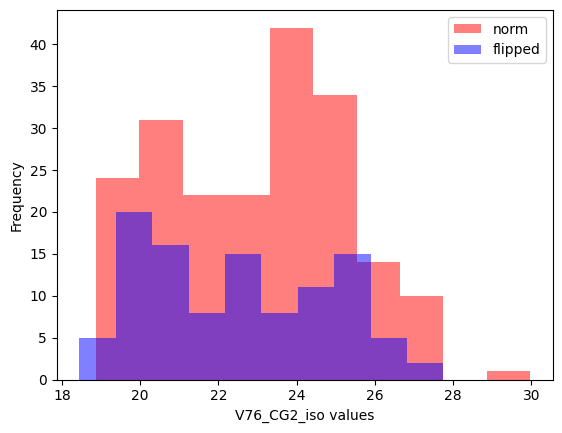

In [ ]:
#now plot N distribution
# Create a figure and axis
# Separate iso values based on the 'class'
df=N_V76_pd
class_0_iso = df[df['class'] == 0]['iso']
class_1_iso = df[df['class'] == 1]['iso']

# Plotting
plt.hist(class_0_iso, alpha=0.5, color='red', label='norm')
plt.hist(class_1_iso, alpha=0.5, color='blue', label='flipped')
plt.xlabel('V76_CG2_iso values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

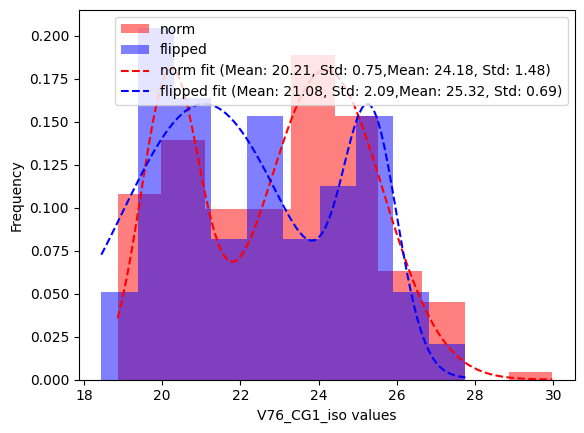

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Function for the sum of two Gaussian distributions
def double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return (
        A1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) + 
        A2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)
    )

# Your existing DataFrame
df = N_V76_pd

# Data for the two classes
class_0_iso = df[df['class'] == 0]['iso']
class_1_iso = df[df['class'] == 1]['iso']

# Plotting histograms
plt.hist(class_0_iso, alpha=0.5, color='red', label='norm', density=True)
plt.hist(class_1_iso, alpha=0.5, color='blue', label='flipped', density=True)
plt.xlabel('V76_CG1_iso values')
plt.ylabel('Frequency')

# Gaussian fit to class 0
mu_0, std_0 = np.mean(class_0_iso), np.std(class_0_iso)
x_0 = np.linspace(min(class_0_iso), max(class_0_iso), 100)
hist_0, bins_0 = np.histogram(class_0_iso, bins=30, density=True)
params_0, _ = curve_fit(
    double_gaussian, 
    0.5 * (bins_0[1:] + bins_0[:-1]), 
    hist_0, 
    #p0=[61, 3, 1,70, 4, 1],
    #p0=[110, 3, 1,120, 4, 1],
    #p0=[175, 3, 1,179, 4, 1],
    #p0=[33.5, 3, 1, 35.5, 4, 1],
    p0=[20, 2, 0.2, 25, 2, 0.2],
    maxfev=5000  # Increase maxfev from the default value
)
plt.plot(
    x_0, 
    double_gaussian(x_0, *params_0), 
    color='red', 
    linestyle='--', 
    label=f'norm fit (Mean: {params_0[0]:.2f}, Std: {params_0[1]:.2f},Mean: {params_0[3]:.2f}, Std: {params_0[4]:.2f})'
)

# Gaussian fit to class 1
mu_1, std_1 = np.mean(class_1_iso), np.std(class_1_iso)
x_1 = np.linspace(min(class_1_iso), max(class_1_iso), 100)
hist_1, bins_1 = np.histogram(class_1_iso, bins=30, density=True)
params_1, _ = curve_fit(
    double_gaussian, 
    0.5 * (bins_1[1:] + bins_1[:-1]), 
    hist_1, 
    #p0=[61, 3, 1,70, 4, 1],
    #p0=[110, 3, 1,120, 4, 1],
    #p0=[174, 3, 1,180, 4, 1],
    #p0=[33.5, 3, 1, 35.5, 4, 1],
    p0=[20, 2, 0.2, 25, 2, 0.2],
    maxfev=5000  # Increase maxfev from the default value
)
plt.plot(
    x_1, 
    double_gaussian(x_1, *params_1), 
    color='blue', 
    linestyle='--', 
    label=f'flipped fit (Mean: {params_1[0]:.2f}, Std: {params_1[1]:.2f},Mean: {params_1[3]:.2f}, Std: {params_1[4]:.2f})'
)

plt.legend()
plt.show()


In [ ]:
#adding class label based on torsion angles
for key, df in G77_torsion.items():
    # Add class label based on the torsion angles
    for i, row in df.iterrows():
        if (str(key), row['resNO']-1) in norm_mapped_list: # -1 is used as the mapped list is for V76 
            #print((str(key), row['resNO']))
            G77_torsion[key].loc[i, 'class'] = 0
        else:
            G77_torsion[key].loc[i, 'class'] = 1


In [ ]:
#extract specific atoms chemical shift info
N_G77=[]
CA_G77=[]
C_G77=[]
for entry in G77_torsion.values():
    N_G77.append(entry[entry['atom'] == 'N'])
    CA_G77.append(entry[entry['atom'] == 'CA'])
    C_G77.append(entry[entry['atom'] == 'C'])
    
N_G77_pd=pd.concat(N_G77)
CA_G77_pd=pd.concat(CA_G77)
C_G77_pd=pd.concat(C_G77)
N_G77_pd

,resNO,atom,resNam,iso,delta,ita,alpha,betta,gamma,class
61,56,N,GLY,105.145,98.476,0.317,37.379,169.480,200.706,1.0
179,159,N,GLY,111.395,97.867,0.472,31.738,155.439,201.638,0.0
297,262,N,GLY,100.690,82.975,0.099,57.335,177.710,185.885,1.0
415,365,N,GLY,96.149,92.533,0.038,52.318,189.337,192.897,0.0
61,56,N,GLY,106.670,101.058,0.273,33.272,171.087,198.632,1.0
...,...,...,...,...,...,...,...,...,...,...
415,365,N,GLY,94.745,88.865,0.181,57.390,182.667,198.708,0.0
61,56,N,GLY,97.403,94.344,0.052,49.253,188.306,193.232,1.0
179,159,N,GLY,107.913,97.769,0.415,35.318,161.707,202.237,0.0
297,262,N,GLY,92.939,89.940,0.097,58.121,188.668,197.394,0.0


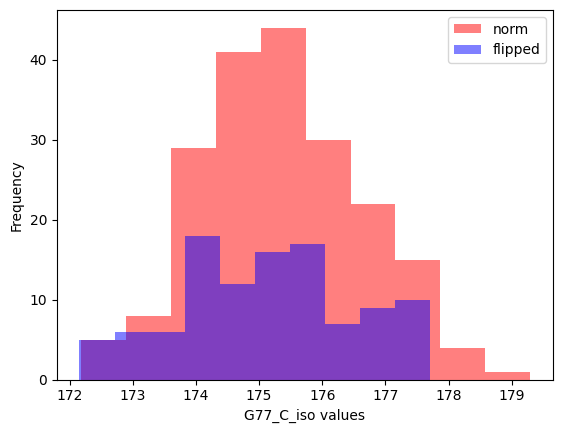

In [ ]:
#now plot N distribution
# Create a figure and axis
# Separate iso values based on the 'class'
df=C_G77_pd
class_0_iso = df[df['class'] == 0]['iso']
class_1_iso = df[df['class'] == 1]['iso']

# Plotting
plt.hist(class_0_iso, alpha=0.5, color='red', label='norm')
plt.hist(class_1_iso, alpha=0.5, color='blue', label='flipped')
plt.xlabel('G77_C_iso values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

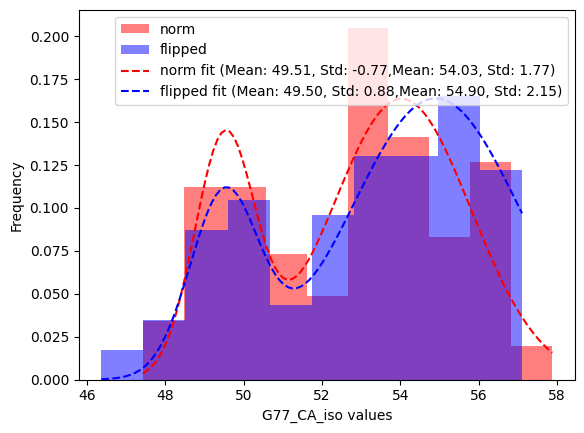

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Function for the sum of two Gaussian distributions
def double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return (
        A1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) + 
        A2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)
    )

# Your existing DataFrame
df = CA_G77_pd

# Data for the two classes
class_0_iso = df[df['class'] == 0]['iso']
class_1_iso = df[df['class'] == 1]['iso']

# Plotting histograms
plt.hist(class_0_iso, alpha=0.5, color='red', label='norm', density=True)
plt.hist(class_1_iso, alpha=0.5, color='blue', label='flipped', density=True)
plt.xlabel('G77_CA_iso values')
plt.ylabel('Frequency')

# Gaussian fit to class 0
mu_0, std_0 = np.mean(class_0_iso), np.std(class_0_iso)
x_0 = np.linspace(min(class_0_iso), max(class_0_iso), 100)
hist_0, bins_0 = np.histogram(class_0_iso, bins=30, density=True)
params_0, _ = curve_fit(
    double_gaussian, 
    0.5 * (bins_0[1:] + bins_0[:-1]), 
    hist_0, 
    #p0=[61, 3, 1,70, 4, 1],
    #p0=[110, 3, 1,120, 4, 1],
    #p0=[175, 3, 1,179, 4, 1],
    #p0=[33.5, 3, 1, 35.5, 4, 1],
    p0=[49, 2, 0.2, 54, 2, 0.2],
    maxfev=5000  # Increase maxfev from the default value
)
plt.plot(
    x_0, 
    double_gaussian(x_0, *params_0), 
    color='red', 
    linestyle='--', 
    label=f'norm fit (Mean: {params_0[0]:.2f}, Std: {params_0[1]:.2f},Mean: {params_0[3]:.2f}, Std: {params_0[4]:.2f})'
)

# Gaussian fit to class 1
mu_1, std_1 = np.mean(class_1_iso), np.std(class_1_iso)
x_1 = np.linspace(min(class_1_iso), max(class_1_iso), 100)
hist_1, bins_1 = np.histogram(class_1_iso, bins=30, density=True)
params_1, _ = curve_fit(
    double_gaussian, 
    0.5 * (bins_1[1:] + bins_1[:-1]), 
    hist_1, 
    #p0=[61, 3, 1,70, 4, 1],
    #p0=[110, 3, 1,120, 4, 1],
    #p0=[174, 3, 1,180, 4, 1],
    #p0=[33.5, 3, 1, 35.5, 4, 1],
    p0=[49, 2, 0.2, 54, 2, 0.2],
    maxfev=5000  # Increase maxfev from the default value
)
plt.plot(
    x_1, 
    double_gaussian(x_1, *params_1), 
    color='blue', 
    linestyle='--', 
    label=f'flipped fit (Mean: {params_1[0]:.2f}, Std: {params_1[1]:.2f},Mean: {params_1[3]:.2f}, Std: {params_1[4]:.2f})'
)

plt.legend()
plt.show()

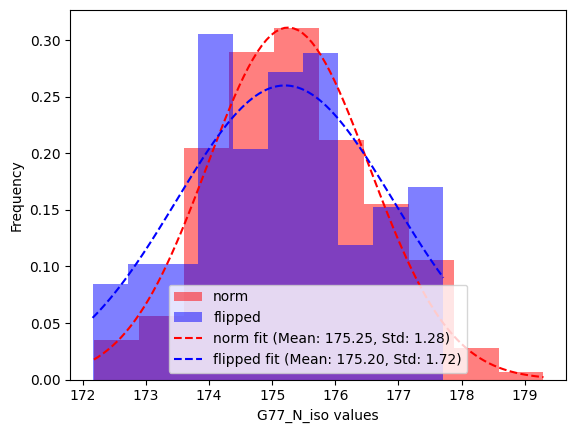

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Function for Gaussian distribution
def gaussian(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
df=C_G77_pd

# Data
class_0_iso = df[df['class'] == 0]['iso']
class_1_iso = df[df['class'] == 1]['iso']

# Plotting histograms
plt.hist(class_0_iso, alpha=0.5, color='red', label='norm', density=True)
plt.hist(class_1_iso, alpha=0.5, color='blue', label='flipped', density=True)
plt.xlabel('G77_N_iso values')
plt.ylabel('Frequency')

# Gaussian fit to class 0
mu_0, std_0 = np.mean(class_0_iso), np.std(class_0_iso)
x_0 = np.linspace(min(class_0_iso), max(class_0_iso), 100)
hist_0, bins_0 = np.histogram(class_0_iso, bins=30, density=True)
params_0, _ = curve_fit(gaussian, 0.5 * (bins_0[1:] + bins_0[:-1]), hist_0, p0=[mu_0, std_0, 1])
plt.plot(x_0, gaussian(x_0, *params_0), color='red', linestyle='--', label=f'norm fit (Mean: {params_0[0]:.2f}, Std: {params_0[1]:.2f})')

# Gaussian fit to class 1
mu_1, std_1 = np.mean(class_1_iso), np.std(class_1_iso)
x_1 = np.linspace(min(class_1_iso), max(class_1_iso), 100)
hist_1, bins_1 = np.histogram(class_1_iso, bins=30, density=True)
params_1, _ = curve_fit(gaussian, 0.5 * (bins_1[1:] + bins_1[:-1]), hist_1, p0=[mu_1, std_1, 1])
plt.plot(x_1, gaussian(x_1, *params_1), color='blue', linestyle='--', label=f'flipped fit (Mean: {params_1[0]:.2f}, Std: {params_1[1]:.2f})')

plt.legend()
#plt.savefig('N_')
plt.show()


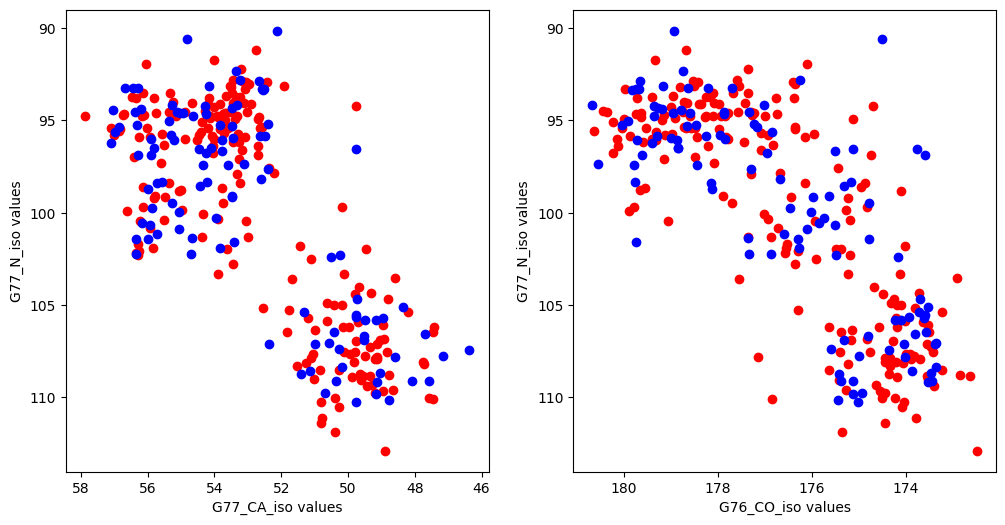

In [ ]:
#plot NCA and NCO
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(12,6))
df1=N_G77_pd
df2=CA_G77_pd
df3=CO_V76_pd
# Data
Nclass_0_iso = df1[df1['class'] == 0]['iso']
Nclass_1_iso = df1[df1['class'] == 1]['iso']
CAclass_0_iso = df2[df2['class'] == 0]['iso']
CAclass_1_iso = df2[df2['class'] == 1]['iso']
COclass_0_iso = df3[df3['class'] == 0]['iso']
COclass_1_iso = df3[df3['class'] == 1]['iso']

ax1.plot(CAclass_0_iso,Nclass_0_iso,'ro')
ax1.plot(CAclass_1_iso,Nclass_1_iso,'bo')

ax1.set_ylabel('G77_N_iso values')
ax1.set_xlabel('G77_CA_iso values')

ax1.invert_xaxis()
ax1.invert_yaxis()


ax2.plot(COclass_0_iso,Nclass_0_iso,'ro')
ax2.plot(COclass_1_iso,Nclass_1_iso,'bo')

ax2.set_ylabel('G77_N_iso values')
ax2.set_xlabel('G76_CO_iso values')

ax2.invert_xaxis()
ax2.invert_yaxis()


Text(0, 0.5, '$^{15}$N Shift (ppm)')

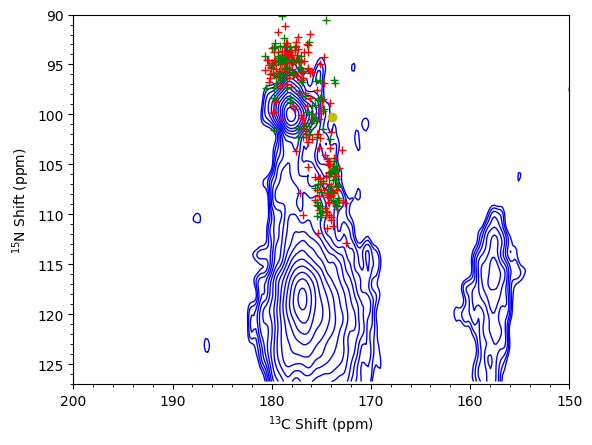

In [ ]:
#import NMR data and overlay with the above plot
cord_dir = "/Users/yunyao_1/Documents/Experiments_Data/data/Oct23_1.9mm_KcsA_V94AG116_DM_gammaCD2/127/pdata/1"
dic, data = ng.bruker.read_pdata(cord_dir)

udic = ng.bruker.guess_udic(dic, data)
uc1 = ng.fileiobase.uc_from_udic(udic, dim=1) # direct C
uc0 = ng.fileiobase.uc_from_udic(udic, dim=0)  # indirect N
ppm1 = uc1.ppm_scale()
ppm0 = uc0.ppm_scale()

noise = np.std(data[uc1(300, 'ppm'):uc1(280, 'ppm'), uc0(120, 'ppm'):uc0(110, 'ppm')])

levels = noise* 1.25**np.arange(16) * 3
lims=[[200,150],[127,90]]

plt.contour(ppm1, ppm0, data, levels, colors='blue', linewidths=1)
plt.plot(COclass_0_iso,Nclass_0_iso,'r+')
plt.plot(COclass_1_iso,Nclass_1_iso,'g+')
#plot assignment from chemical shift table
plt.plot(173.88,100.3,'yo')
plt.xlim(lims[0])
plt.ylim(lims[1])
plt.minorticks_on()
plt.xlabel(r'$^{13}$C Shift (ppm)')
plt.ylabel(r'$^{15}$N Shift (ppm)')

Text(0, 0.5, 'V76_psi')

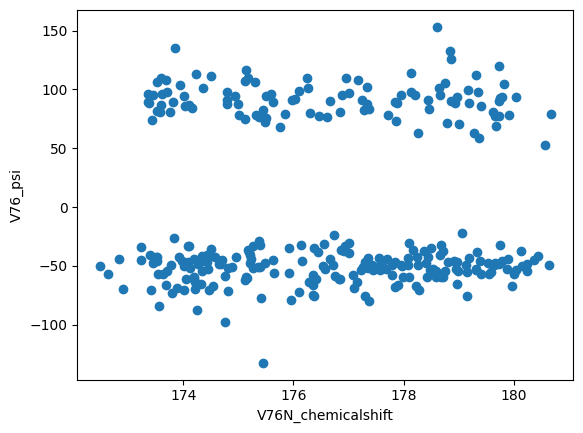

In [ ]:
# in the following plot the correlation between CS and torsion angle
#first read in the torsion angle file
file_path='./minimalized_v76_phi_angle'
v76_psi_pd = pd.read_csv(file_path,index_col=0)
len(v76_psi_pd)
# Map letters to numbers
#letter_to_number = {'a': 261, 'b': 55, 'c': 158, 'd': 364}
new_column_names = {'a': 261, 'b': 55, 'c': 158, 'd': 364}
v76_psi_pd = v76_psi_pd.rename(columns=new_column_names)
'''
v76_psi_pd
	261	55	158	364
800	87.969692	75.243872	-33.009498	-49.128601
380	-46.480520	99.688054	-49.195144	-49.667004
960	76.989013	90.937699	-48.759930	-52.698918
790	75.680854	105.981975	-40.734965	-54.853080
550	-49.549937	95.153985	-44.549700	-32.81623

'''

#assign torsion angle values to the V76_torsion
#V76_torsion in dictionary fortmat{'index': df}
#adding class label based on torsion angles
for key, df in V76_torsion.items():
    # Add class label based on the torsion angles
    for i, row in df.iterrows():
        #if (str(key), row['resNO']-1) in norm_mapped_list: # -1 is used as the mapped list is for V76 
        V76_torsion[key].loc[i, 'psi'] = v76_psi_pd.loc[key, row['resNO']]
        #print(v76_psi_pd.loc[key, row['resNO']])
#a glime of new V76_torsion
#print(V76_torsion[10].head())
'''
    resNO atom resNam      iso    delta    ita    alpha    betta    gamma  \
46     55    N    VAL  119.184  101.090  0.130   20.726  165.773  178.949   
48     55   CA    VAL   70.435  -20.472  0.161  107.483  110.775  139.837   
50     55   CB    VAL   35.796  -14.684  0.522  142.828  150.495  168.688   
52     55  CG1    VAL   22.684  -28.787  0.321  148.096  157.350  195.903   
56     55  CG2    VAL   24.370  -22.954  0.453  148.752  159.154  188.384   

    class        psi  
46    0.0 -42.241518  
48    0.0 -42.241518  
50    0.0 -42.241518  
52    0.0 -42.241518  
56    0.0 -42.241518 

'''

# as priviously we did, extra and then concat one nuclei at a time
N_V76=[]
CO_V76=[]
CA_V76=[]
CB_V76=[]
for entry in V76_torsion.values():
    N_V76.append(entry[entry['atom'] == 'N'])
    CO_V76.append(entry[entry['atom'] == 'C'])
    CA_V76.append(entry[entry['atom'] == 'CA'])
    CB_V76.append(entry[entry['atom'] == 'CB'])

N_V76_pd=pd.concat(N_V76)
CO_V76_pd=pd.concat(CO_V76)
CA_V76_pd=pd.concat(CA_V76)
CB_V76_pd=pd.concat(CB_V76)

# A glime of N_V76_pd
'''
	resNO	atom	resNam	iso	delta	ita	alpha	betta	gamma	class	psi
46	55	N	VAL	110.974	101.037	0.099	28.989	175.562	185.526	1.0	105.981975
164	158	N	VAL	109.840	104.400	0.132	26.760	176.483	190.237	0.0	-40.734965
282	261	N	VAL	113.950	110.260	0.127	16.790	175.174	189.185	1.0	75.680854
'''
#now plot the iso and psi
plt.plot(CO_V76_pd['iso'],CO_V76_pd['psi'],'o')
plt.xlabel('V76N_chemicalshift')
plt.ylabel('V76_psi')

Text(0, 0.5, 'V76_chi1')

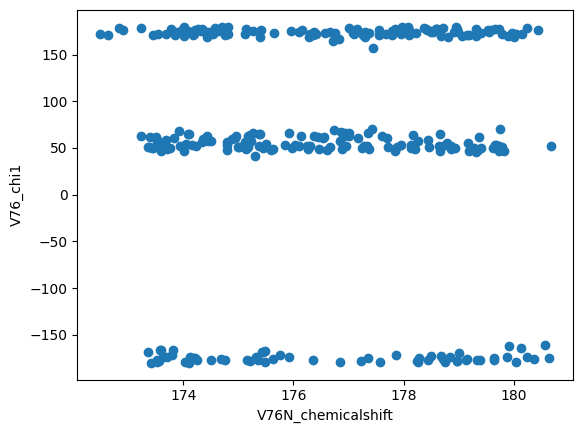

In [ ]:
# in the following plot the correlation between CS and chi1 angle
#first read in the torsion angle file
file_path='./minimalized_v76_chi1_angle'
v76_chi1_pd = pd.read_csv(file_path,index_col=0)
#len(v76_psi_pd)
# Map letters to numbers
#letter_to_number = {'a': 261, 'b': 55, 'c': 158, 'd': 364}
new_column_names = {'a': 261, 'b': 55, 'c': 158, 'd': 364}
v76_chi1_pd = v76_chi1_pd.rename(columns=new_column_names)


#assign torsion angle values to the V76_torsion
#V76_torsion in dictionary fortmat{'index': df}
#adding class label based on torsion angles
for key, df in V76_torsion.items():
    # Add class label based on the torsion angles
    for i, row in df.iterrows():
        #if (str(key), row['resNO']-1) in norm_mapped_list: # -1 is used as the mapped list is for V76 
        V76_torsion[key].loc[i, 'chi1'] = v76_chi1_pd.loc[key, row['resNO']]
        #print(v76_psi_pd.loc[key, row['resNO']])
#a glime of new V76_torsion
#print(V76_torsion[10].head())

# as priviously we did, extra and then concat one nuclei at a time
N_V76=[]
CO_V76=[]
CA_V76=[]
CB_V76=[]
for entry in V76_torsion.values():
    N_V76.append(entry[entry['atom'] == 'N'])
    CO_V76.append(entry[entry['atom'] == 'C'])
    CA_V76.append(entry[entry['atom'] == 'CA'])
    CB_V76.append(entry[entry['atom'] == 'CB'])

N_V76_pd=pd.concat(N_V76)
CO_V76_pd=pd.concat(CO_V76)
CA_V76_pd=pd.concat(CA_V76)
CB_V76_pd=pd.concat(CB_V76)

# A glime of N_V76_pd
'''
	resNO	atom	resNam	iso	delta	ita	alpha	betta	gamma	class	psi
46	55	N	VAL	110.974	101.037	0.099	28.989	175.562	185.526	1.0	105.981975
164	158	N	VAL	109.840	104.400	0.132	26.760	176.483	190.237	0.0	-40.734965
282	261	N	VAL	113.950	110.260	0.127	16.790	175.174	189.185	1.0	75.680854
'''
#now plot the iso and psi
plt.plot(CO_V76_pd['iso'],CO_V76_pd['chi1'],'o')
plt.xlabel('V76N_chemicalshift')
plt.ylabel('V76_chi1')

Text(0, 0.5, 'V76_chi1')

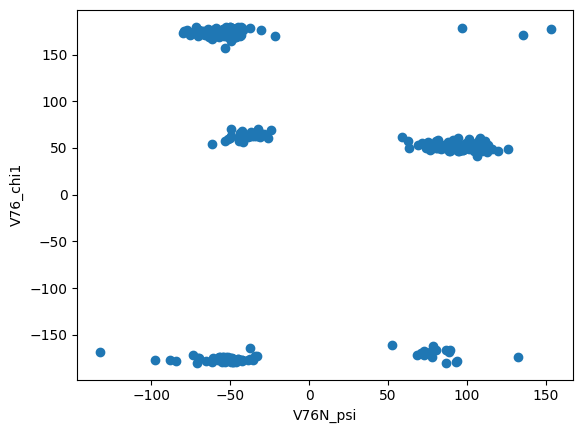

In [ ]:
plt.plot(CO_V76_pd['psi'],CO_V76_pd['chi1'],'o')
plt.xlabel('V76N_psi')
plt.ylabel('V76_chi1')

array([-5.34109836,  2.74379538,  1.37274426,  3.66022623, -0.25931023,
       -2.2906    ,  4.64568977])

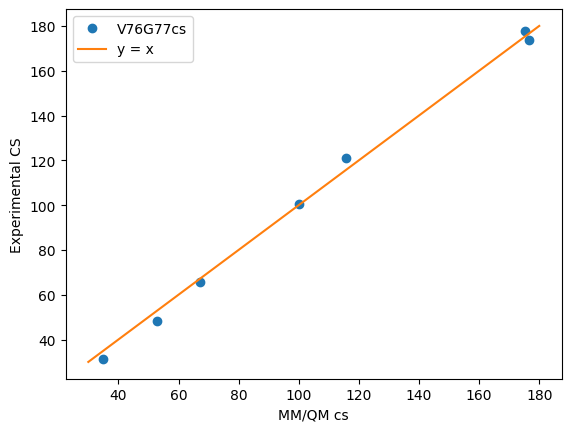

In [ ]:
#compare the mean of predict cs to experiemntal ones
# chemicsl shift V76 N CO CA CB G77 N CO CA
#pre_cs=[]
pre_cs=[N_V76_pd['iso'].mean(), CO_V76_pd['iso'].mean(), CA_V76_pd['iso'].mean(), CB_V76_pd['iso'].mean(),N_G77_pd['iso'].mean(), C_G77_pd['iso'].mean(), CA_G77_pd['iso'].mean()]
exp_cs=[121.2,173.88,65.66,31.3,100.3,177.58,48.2]
plt.plot(pre_cs,exp_cs,'o',label='V76G77cs')
plt.xlabel('MM/QM cs')
plt.ylabel('Experimental CS')
x = range(30, 181)

# y = x (y is equal to x)
y = range(30, 181)

# Plot the line y = x
plt.plot(x, y, label='y = x')
plt.legend()
np.array(pre_cs)-np.array(exp_cs)

In [ ]:
# Extract 'N' atom 'iso' values and their corresponding classes
# #extra Iso data 
# N_=[]
# C_=[]
# CA_=[]
# CB_=[]
# CG2_=[]
# Thr54_df=pd.DataFrame(columns=['N','C','CA','CB','CG2'])
# for keys, item in cc0111_dict.items():
#     if item.loc[(values['resNO'] in list([]))&(item['atom']=='N')]['iso'].values.size!=0:
#         N_.append(item.loc[(values['resNO']==54)&(item['atom']=='N')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='C')]['iso'].values.size!=0:
#         C_.append(item.loc[(values['resNO']==54)&(item['atom']=='C')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CA')]['iso'].values.size!=0:
#         CA_.append(item.loc[(values['resNO']==54)&(item['atom']=='CA')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CB')]['iso'].values.size!=0:
#         CB_.append(item.loc[(values['resNO']==54)&(item['atom']=='CB')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CG2')]['iso'].values.size!=0:
#         CG2_.append(item.loc[(values['resNO']==54)&(item['atom']=='CG2')]['iso'].values[0])
# #     if item.loc[(values['resNO']==54)&(item['atom']=='C')]['iso'].size==0:
# #         print(keys)
# # Thr54_df['N']=N_Thr54
# # Thr54_df['C']=C_Thr54
# # Thr54_df['CA']=CA_Thr54
# # Thr54_df['CB']=CB_Thr54
# # Thr54_df['CG2']=CG2_Thr54
# # Thr54_df.index=cc0111_dict.keys()
# C_

In [ ]:
#a
cc0111_dict['results_960'].loc[(cc0111_dict['results_960']['resNO']==54)&(cc0111_dict['results_960']['atom']=='C')]['iso'].values[0]

177.538

In [ ]:
#data analysis
#extra Iso data 
# N_Thr54=[]
# C_Thr54=[]
# CA_Thr54=[]
# CB_Thr54=[]
# CG2_Thr54=[]
# Thr54_df=pd.DataFrame(columns=['N','C','CA','CB','CG2'])
# for keys, values in cc0111_dict.items():
#     if item.loc[(values['resNO']==54)&(item['atom']=='N')]['iso'].values.size!=0:
#         N_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='N')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='C')]['iso'].values.size!=0:
#         C_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='C')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CA')]['iso'].values.size!=0:
#         CA_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='CA')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CB')]['iso'].values.size!=0:
#         CB_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='CB')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CG2')]['iso'].values.size!=0:
#         CG2_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='CG2')]['iso'].values[0])
# #     if item.loc[(values['resNO']==54)&(item['atom']=='C')]['iso'].size==0:
# #         print(keys)
# Thr54_df['N']=N_Thr54
# Thr54_df['C']=C_Thr54
# Thr54_df['CA']=CA_Thr54
# Thr54_df['CB']=CB_Thr54
# Thr54_df['CG2']=CG2_Thr54
# Thr54_df.index=cc0111_dict.keys()

In [ ]:
# for keys, values in cc0111_dict.items():
#     if values.loc[(values['resNO']==54)&(item['atom']=='N')]['iso'].values.size!=0:
#         print(values.loc[(values['resNO']==54)&(item['atom']=='N')]['iso'].values[0])

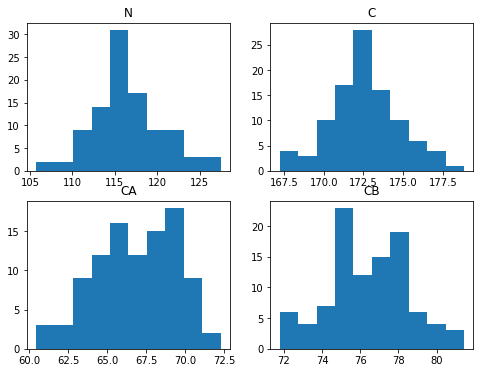

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(8, 6))
axs=axs.ravel()
for idx, ax in enumerate (axs):
    ax.hist(Thr54_df.iloc[:,idx])
    ax.set_title(Thr54_df.columns[idx])

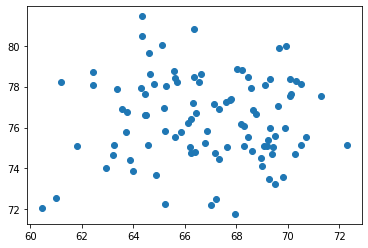

In [ ]:
plt.scatter(Thr54_df['CA'],Thr54_df['CB'])

In [ ]:
#extra Iso data 
N_Gly77=[]
C_Gly77=[]
CA_Gly77=[]
Gly77_df=pd.DataFrame(columns=['N','C','CA','CB','CG2'])
for keys, values in cc0111_dict.items():
    if values.loc[(values['resNO']==56)&(values['atom']=='N')]['iso'].values.size!=0:
        N_Gly77.append(values.loc[(values['resNO']==56)&(values['atom']=='N')]['iso'].values[0])
    if values.loc[(values['resNO']==56)&(values['atom']=='C')]['iso'].values.size!=0:
        C_Gly77.append(values.loc[(values['resNO']==56)&(values['atom']=='C')]['iso'].values[0])
    if values.loc[(values['resNO']==56)&(values['atom']=='CA')]['iso'].values.size!=0:
        CA_Gly77.append(values.loc[(values['resNO']==56)&(values['atom']=='CA')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CB')]['iso'].values.size!=0:
#         CB_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='CB')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CG2')]['iso'].values.size!=0:
#         CG2_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='CG2')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='C')]['iso'].size==0:
#         print(keys)
Gly77_df['N']=N_Gly77
Gly77_df['C']=C_Gly77
Gly77_df['CA']=CA_Gly77
#Thr54_df['CB']=CB_Thr54
#Thr54_df['CG2']=CG2_Thr54
Gly77_df.index=cc0111_dict.keys()

In [ ]:
Gly77_df

,N,C,CA,CB,CG2
results_790,103.888,177.491,44.930,NaN,NaN
results_960,106.633,178.556,52.805,NaN,NaN
results_380,99.266,177.792,55.585,NaN,NaN
results_60,101.688,172.989,52.759,NaN,NaN
results_800,107.756,181.756,58.437,NaN,NaN
...,...,...,...,...,...
results_830,107.383,178.228,48.282,NaN,NaN
results_50,110.465,179.385,59.585,NaN,NaN
results_170,88.117,175.317,56.588,NaN,NaN
results_400,82.470,171.781,57.043,NaN,NaN


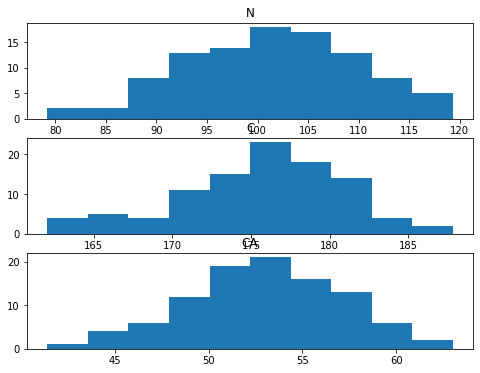

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(8, 6))
axs=axs.ravel()
for idx, ax in enumerate (axs):
    ax.hist(Gly77_df.iloc[:,idx])
    ax.set_title(Gly77_df.columns[idx])

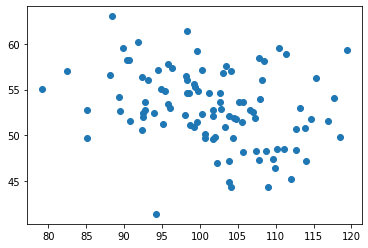

In [ ]:
plt.scatter(Gly77_df['N'],Gly77_df['CA'])

In [ ]:
#extra Iso data 
N_Val76=[]
C_Val76=[]
CA_Val76=[]
Val76_df=pd.DataFrame(columns=['N','C','CA','CB','CG2'])
for keys, values in cc0111_dict.items():
    if values.loc[(values['resNO']==55)&(values['atom']=='N')]['iso'].values.size!=0:
        N_Val76.append(values.loc[(values['resNO']==55)&(values['atom']=='N')]['iso'].values[0])
    if values.loc[(values['resNO']==55)&(values['atom']=='C')]['iso'].values.size!=0:
        C_Val76.append(values.loc[(values['resNO']==55)&(values['atom']=='C')]['iso'].values[0])
    if values.loc[(values['resNO']==55)&(values['atom']=='CA')]['iso'].values.size!=0:
        CA_Val76.append(values.loc[(values['resNO']==55)&(values['atom']=='CA')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CB')]['iso'].values.size!=0:
#         CB_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='CB')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='CG2')]['iso'].values.size!=0:
#         CG2_Thr54.append(item.loc[(values['resNO']==54)&(item['atom']=='CG2')]['iso'].values[0])
#     if item.loc[(values['resNO']==54)&(item['atom']=='C')]['iso'].size==0:
#         print(keys)
Val76_df['N']=N_Val76
Val76_df['C']=C_Val76
Val76_df['CA']=CA_Val76
#Thr54_df['CB']=CB_Thr54
#Thr54_df['CG2']=CG2_Thr54
Val76_df.index=cc0111_dict.keys()

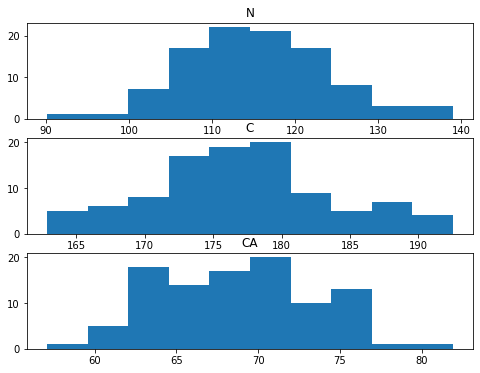

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(8, 6))
axs=axs.ravel()
for idx, ax in enumerate (axs):
    ax.hist(Val76_df.iloc[:,idx])
    ax.set_title(Val76_df.columns[idx])

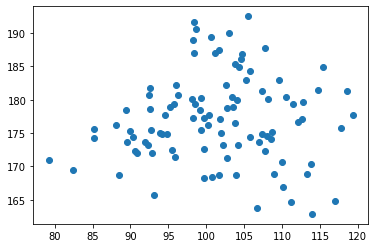

In [ ]:
plt.scatter(Gly77_df['N'],Val76_df['C'])

In [ ]:
num=cc0111_dict['results_960']['resNO'].values
num2=[*set(num)]
df_resNO=[]
for resNO in num2:
    df_resNO.append(str(resNO)+'_df')
    
df_resNO

['258_df',
 '259_df',
 '260_df',
 '261_df',
 '361_df',
 '362_df',
 '363_df',
 '364_df',
 '52_df',
 '53_df',
 '54_df',
 '55_df',
 '155_df',
 '156_df',
 '157_df',
 '158_df']

In [ ]:
CC_total={}
for idx, df in zip(num2,df_resNO):
    N_cc=[]
    C_cc=[]
    CA_cc=[]
    CB_cc=[]
    CG2_cc=[]
    CG1_cc=[]
    CC_total[df]=pd.DataFrame(columns=['N','C','CA','CB','CG1','CG2'])
    for keys, item in cc0111_dict.items():
        if  item.loc[(values['resNO']==idx)&(item['atom']=='N')]['iso'].values.size!=0:
            N_cc.append(item.loc[(values['resNO']==idx)&(item['atom']=='N')]['iso'].values[0])
        if item.loc[(values['resNO']==idx)&(item['atom']=='C')]['iso'].values.size!=0:
            C_cc.append(item.loc[(values['resNO']==idx)&(item['atom']=='C')]['iso'].values[0])        
        if item.loc[(values['resNO']==idx)&(item['atom']=='CA')]['iso'].values.size!=0:
            CA_cc.append(item.loc[(values['resNO']==idx)&(item['atom']=='CA')]['iso'].values[0])
        if item.loc[(values['resNO']==idx)&(item['atom']=='CB')]['iso'].values.size!=0:
            CB_cc.append(item.loc[(values['resNO']==idx)&(item['atom']=='CB')]['iso'].values[0])
        if item.loc[(values['resNO']==idx)&(item['atom']=='CG2')]['iso'].values.size!=0:
            CG2_cc.append(item.loc[(values['resNO']==idx)&(item['atom']=='CG2')]['iso'].values[0])
    #         print(keys)
    CC_total[df]['N']=pd.Series(N_cc)
    CC_total[df]['C']=pd.Series(C_cc)
    CC_total[df]['CA']=pd.Series(CA_cc)
    CC_total[df]['CB']=pd.Series(CB_cc)
    CC_total[df]['CG2']=pd.Series(CG2_cc)
    CC_total[df]['CG1']=pd.Series(CG1_cc)
    CC_total[df].index=cc0111_dict.keys()

<ipython-input-173-a33823cf7bfc>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  CC_total[df]['N']=pd.Series(N_cc)
<ipython-input-173-a33823cf7bfc>:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  CC_total[df]['C']=pd.Series(C_cc)
<ipython-input-173-a33823cf7bfc>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  CC_total[df]['CA']=pd.Series(CA_cc)
<ipython-input-173-a33823cf7bfc>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  CC_total[df]['CB']=pd.Series(CB_cc)
<ipython-input-173-a33823cf7bfc>:26: Dep

ValueError: Length mismatch: Expected axis has 0 elements, new values have 100 elements

In [ ]:
CC_total.keys()

dict_keys(['258_df', '259_df', '260_df', '261_df', '361_df', '362_df', '363_df', '364_df', '52_df', '53_df', '54_df', '55_df', '155_df', '156_df', '157_df', '158_df'])

array([[<AxesSubplot:title={'center':'N'}>,
        <AxesSubplot:title={'center':'C'}>],
       [<AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CB'}>],
       [<AxesSubplot:title={'center':'CG1'}>,
        <AxesSubplot:title={'center':'CG2'}>]], dtype=object)

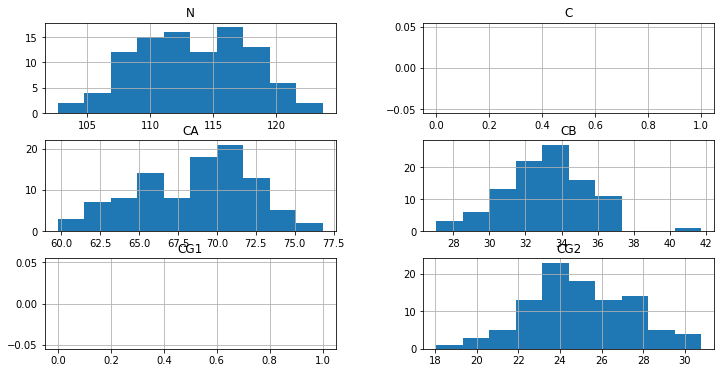

In [ ]:
CC_total['55_df'].hist(figsize=(12,6))

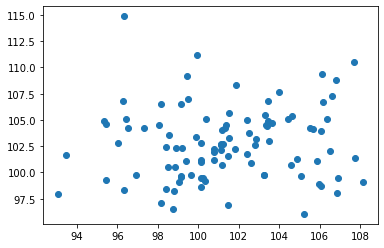

In [ ]:
# correlation between monomers
plt.scatter(CC_total['53_df']['N'],CC_total['156_df']['N'])

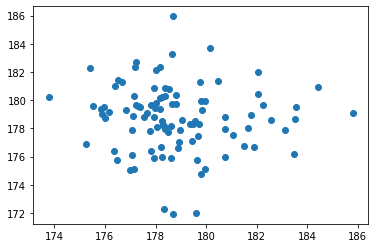

In [ ]:
# correlation between monomers
plt.scatter(CC_total['53_df']['C'],CC_total['156_df']['C'])